# 🖼️ Image Segmentation with U-Net – Oxford-IIIT Pet Dataset

## 1. Introduction



**Image segmentation** is a computer vision task that involves partitioning an image into distinct regions or segments that correspond to different objects or parts of objects. Unlike classification (which predicts a single label per image) or object detection (which predicts bounding boxes), segmentation produces a **pixel-level classification**.

There are three main types of segmentation:
- **Semantic segmentation** – Classifies each pixel into a category (e.g., cat vs background), without distinguishing between individual objects of the same class.
- **Instance segmentation** – Similar to semantic segmentation but differentiates between separate instances of the same object.
- **Panoptic segmentation** – Combines semantic and instance segmentation into one unified view.

In this lab, we focus on **semantic segmentation**.

### Why U-Net?
U-Net is a popular deep learning architecture for segmentation because:
- It uses a **contracting path** (encoder) to capture context and a **symmetric expanding path** (decoder) for precise localization.
- The **skip connections** between encoder and decoder help preserve spatial details lost during downsampling.
- Originally designed for biomedical image segmentation, but widely applicable to many domains.

### Oxford-IIIT Pet Dataset Overview

The **Oxford-IIIT Pet Dataset** is a widely used benchmark for **image classification** and **semantic segmentation** tasks in computer vision.  
It was created by the **Visual Geometry Group (VGG)** at the University of Oxford and contains **37 categories of pet breeds** (cats and dogs), with approximately **200 images per class**.

---

#### 📂 Dataset Composition

- **Total Classes:** 37 (12 cat breeds, 25 dog breeds)
- **Images per Class:** ~200
- **Total Images:** 7,349
- **Image Resolution:** Varies
- **Labels:** Each image is assigned a breed label (integer + string name)
- **Segmentation Masks:** Each image has an annotated mask showing:
  - **Class 1** → Pet
  - **Class 2** → Pet border
  - **Class 3** → Background

---

#### 🔹 Dataset Splits
| Split | Number of Samples |
|-------|------------------|
| Train | 3,680 |
| Test  | 3,669 |

---

#### 🏷 Class Labels

The dataset contains the following **37 pet breeds**:
Abyssinian, American_bulldog, American_pit_bull_terrier, Bengal, Birman, Bombay, British_Shorthair,
Chihuahua, Egyptian_Mau, English_cocker_spaniel, English_setter, German_shorthaired, Great_Pyrenees,
Havanese, Japanese_chin, Keeshond, Leonberger, Maine_Coon, Miniature_pinscher,
Newfoundland, Persian, Pomeranian, Pug, Ragdoll, Russian_Blue, Saint_Bernard,
Samoyed, Scottish_Terrier, Shiba_Inu, Siamese, Sphynx, Staffordshire_bull_terrier,
Wheaten_terrier, Yorkie, boxer, dachshund, doberman

By the end of this lab, you will:
1. Understand the concept of semantic segmentation.
2. Implement a U-Net model from scratch (and optionally compare with a pretrained backbone).
3. Train and evaluate the model on the Oxford-IIIT Pet dataset.
4. Visualize segmentation results for qualitative assessment.


## 2. Dataset Exploration

We will:
1. Load a sample of the dataset.
2. Display images alongside their masks.
3. Understand the pixel label distribution.


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load Oxford-IIIT Pet dataset
dataset, info = tfds.load("oxford_iiit_pet", with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.I9MRSS_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.I9MRSS_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [2]:
print(info)

# Optional: show class names
print("Classes:", info.features['label'].names)
print("Number of classes:", info.features['label'].num_classes)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

In [3]:
info.features

FeaturesDict({
    'file_name': Text(shape=(), dtype=string),
    'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
})

In [4]:
print("Image shape:", info.features['image'].shape)
print("Segmentation mask shape:", info.features['segmentation_mask'].shape)
print("Number of classes:", info.features['label'].num_classes)
print("Class names:", info.features['label'].names)
print("Training set size:", info.splits['train'].num_examples)
print("Test set size:", info.splits['test'].num_examples)


Image shape: (None, None, 3)
Segmentation mask shape: (None, None, 1)
Number of classes: 37
Class names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
Training set size: 3680
Test set size: 3669


## 3. Preprocessing

In [5]:
IMG_SIZE = 128  # Resize images to this size


# Normalize images to [0,1]
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.int32)
    return input_image, input_mask

# Load image and mask from dataset
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        (IMG_SIZE, IMG_SIZE),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

# Data augmentation
@tf.function
def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    return image, mask


# Prepare train/test dataset
BATCH_SIZE = 64
BUFFER_SIZE = 1000

train = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train.cache().shuffle(BUFFER_SIZE).map(augment).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test = dataset['test'].map(load_image)
test_dataset = test.batch(BATCH_SIZE)


## 4. Model (UNET)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(output_channels: int):
    inputs = tf.keras.Input(shape=[128, 128, 3])

    # Encoder (Downsampling)
    down_stack = [
        down_block(64, 3),
        down_block(128, 3),
        down_block(256, 3),
        down_block(512, 3),
    ]

    skips = []
    x = inputs
    for down in down_stack:
        x, skip = down(x)
        skips.append(skip)

    # Bottleneck
    x = conv_block(x, 1024, 3)

    # Decoder (Upsampling)
    skips = reversed(skips)
    up_stack = [
        up_block(512, 3),
        up_block(256, 3),
        up_block(128, 3),
        up_block(64, 3),
    ]

    for up, skip in zip(up_stack, skips):
        x = up(x, skip)

    # Output layer
    outputs = layers.Conv2D(output_channels, (1, 1), activation="softmax")(x)

    return Model(inputs=inputs, outputs=outputs)

# ----------------
# Helper blocks
# ----------------
def conv_block(x, filters, size):
    x = layers.Conv2D(filters, size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def down_block(filters, size):
    def block(x):
        conv = conv_block(x, filters, size)
        pool = layers.MaxPooling2D((2, 2))(conv)
        return pool, conv
    return block

def up_block(filters, size):
    def block(x, skip):
        up = layers.Conv2DTranspose(filters, size, strides=2, padding="same")(x)
        concat = layers.Concatenate()([up, skip])
        conv = conv_block(concat, filters, size)
        return conv
    return block


In [7]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# -----------------------------
# (Optional) Mixed precision for speed on modern GPUs
# -----------------------------
# from tensorflow.keras import mixed_precision
# mixed_precision.set_global_policy("mixed_float16")

# -----------------------------
# Metrics
# -----------------------------
class SparseMeanIoU(tf.keras.metrics.Metric):
    """Mean IoU for sparse integer masks + softmax probabilities."""
    def __init__(self, num_classes, name="mean_iou", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.miou = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true: [B, H, W, 1] int
        # y_pred: [B, H, W, C] probs
        y_true = tf.cast(tf.squeeze(y_true, axis=-1), tf.int32)
        y_pred_labels = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        self.miou.update_state(y_true, y_pred_labels, sample_weight)

    def result(self):
        return self.miou.result()

    def reset_states(self):
        self.miou.reset_states()

def make_dice_metric(num_classes):
    """Macro Dice across classes (treats prediction as probabilities)."""
    def dice_metric(y_true, y_pred):
        y_true = tf.cast(tf.squeeze(y_true, axis=-1), tf.int32)                       # [B,H,W]
        y_true_oh = tf.one_hot(y_true, depth=num_classes, dtype=tf.float32)          # [B,H,W,C]
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)                                  # safety
        inter = tf.reduce_sum(y_true_oh * y_pred, axis=[0, 1, 2])                     # per-class
        union = tf.reduce_sum(y_true_oh + y_pred, axis=[0, 1, 2])
        dice = (2.0 * inter + 1e-7) / (union + 1e-7)                                  # per-class
        return tf.reduce_mean(dice)                                                   # macro
    return dice_metric

# -----------------------------
# Setup
# -----------------------------
OUTPUT_CLASSES = 4  # [background, pet, outline] for Oxford-IIIT Pet
BATCH_SIZE = 32
EPOCHS = 50

train_count = info.splits['train'].num_examples
test_count  = info.splits['test'].num_examples
STEPS_PER_EPOCH = train_count // BATCH_SIZE
VAL_STEPS = test_count // BATCH_SIZE

# -----------------------------
# Build & compile model
# -----------------------------
model = unet_model(OUTPUT_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        'accuracy',
        SparseMeanIoU(num_classes=OUTPUT_CLASSES),
        make_dice_metric(OUTPUT_CLASSES),
    ],
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 34,537,092 (131.75 MB)

 Trainable params: 34,525,316 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [8]:


# -----------------------------
# Callbacks (early stop, LR schedule, best checkpoint, TensorBoard)
# -----------------------------
os.makedirs("checkpoints", exist_ok=True)
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("checkpoints/best_unet.keras", monitor="val_loss", save_best_only=True, verbose=1),
    TensorBoard(log_dir="logs")
]

# -----------------------------
# Train
# -----------------------------
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=test_dataset,
    validation_steps=VAL_STEPS,
    callbacks=callbacks,
    verbose=1
)

# -----------------------------
# Optional: quick evaluation on the validation split
# -----------------------------
eval_results = model.evaluate(test_dataset, steps=VAL_STEPS, verbose=1)
print(dict(zip(model.metrics_names, eval_results)))



Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6718 - dice_metric: 0.3406 - loss: 0.8148 - mean_iou: 0.2918

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 1.36343, saving model to checkpoints/best_unet.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.6724 - dice_metric: 0.3410 - loss: 0.8135 - mean_iou: 0.2922 - val_accuracy: 0.6946 - val_dice_metric: 0.3682 - val_loss: 1.3634 - val_mean_iou: 0.3832 - learning_rate: 0.0010
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.8007 - dice_metric: 0.4485 - loss: 0.5098 - mean_iou: 0.5496
Epoch 2: val_loss improved from 1.36343 to 0.79764, saving model to checkpoints/best_unet.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.8008 - dice_metric: 0.4486 - loss: 0.5096 - mean_iou: 0.5497 - val_accuracy: 0.7389 - val_dice_metric: 0.3962 - val_loss: 0.7976 - val_mean_iou: 0.4292 - learning_rate: 0.0010
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.8360 - dice_metric: 0.4935 - loss: 0.4218 - mean_iou: 0.6109
Epoch 3: val_loss improved from 0.79764 to 0.73982, saving model to checkpoints/best_unet

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


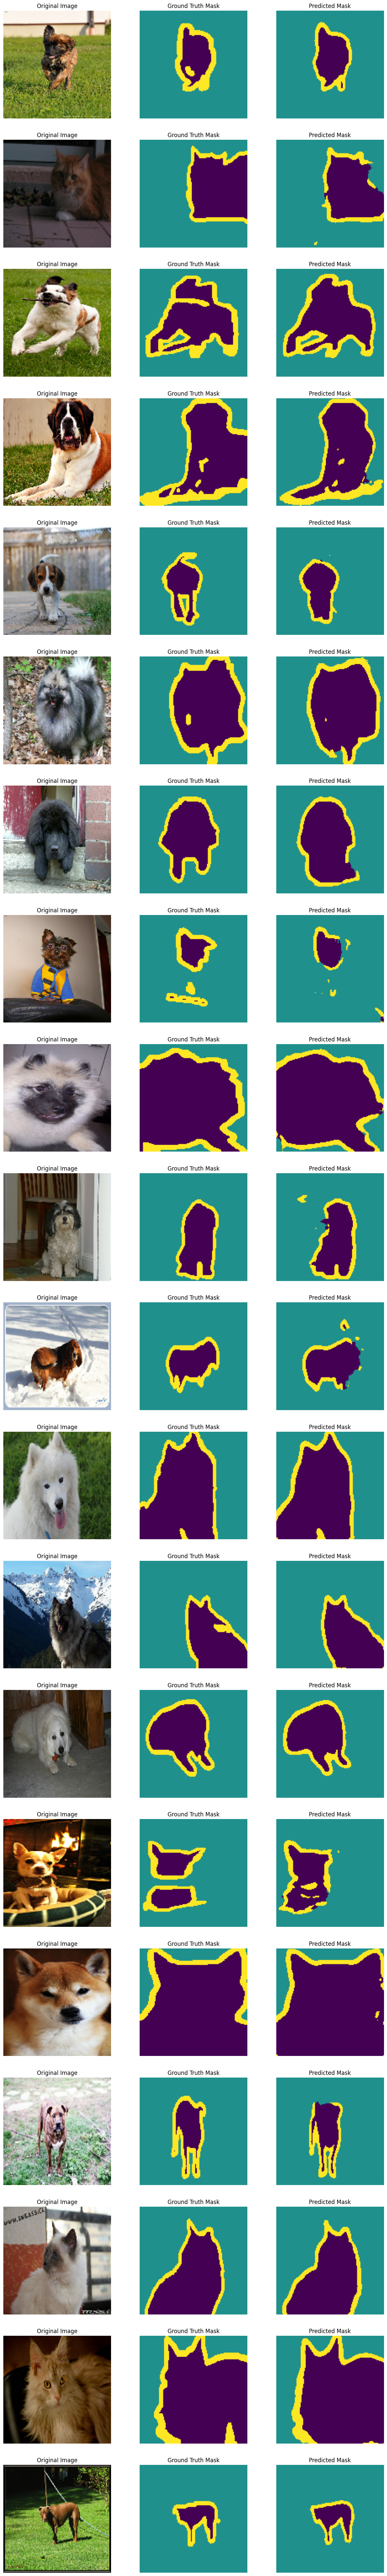

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def display_prediction(model, dataset, num=3):
    """
    Show num samples from dataset with:
    Original image, Ground truth mask, and Predicted mask
    """
    for image, mask in dataset.take(1):
        pred_mask = model.predict(image)
        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = pred_mask[..., tf.newaxis]

        plt.figure(figsize=(15, num * 5))
        for i in range(num):
            plt.subplot(num, 3, i*3 + 1)
            plt.imshow(image[i])
            plt.title("Original Image")
            plt.axis("off")

            plt.subplot(num, 3, i*3 + 2)
            plt.imshow(tf.squeeze(mask[i]))
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.subplot(num, 3, i*3 + 3)
            plt.imshow(tf.squeeze(pred_mask[i]))
            plt.title("Predicted Mask")
            plt.axis("off")
        plt.show()


display_prediction(model, test_dataset, num=20)


58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - accuracy: 0.9179 - dice_metric: 0.6146 - loss: 0.2363 - mean_iou: 0.7725


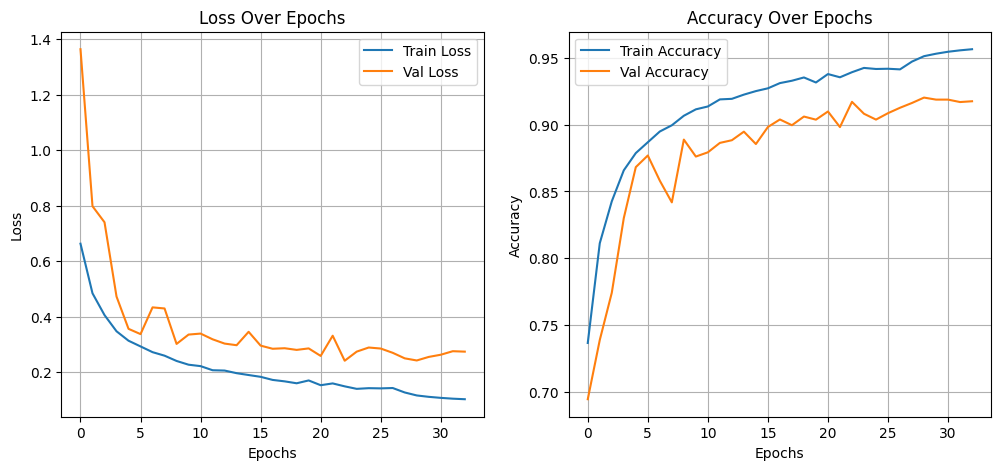

In [16]:
import matplotlib.pyplot as plt
import numpy as np


# Evaluate model on test dataset
results = model.evaluate(test_dataset))


# Plot training curves
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()